# Deterministic hierarchical scale-free walkthrough
Authored by Jorge S. Martinez Armas.

This notebook builds the deterministic hierarchical scale-free network introduced by Ravasz & Barabasi (2003) and walks through how LinkNodeCommunity analyzes its multi-level structure.

We proceed step by step:
1. recap the base motif and its scale-free degree profile,
2. grow the hierarchical network with the `HSF` class,
3. fit the LinkNodeCommunity model and inspect link similarities, and
4. highlight the node communities picked by the average link density score `D`.

**Note:** LinkNodeCommunity is optimized for directed graphs. The results below are therefore qualitative checks meant to illustrate how hubs and their satellites appear in the hierarchy rather than definitive undirected benchmarks.


## Step 1 - Recap the deterministic motif

The Ravasz-Barabasi construction starts from a star-like motif of five nodes: one hub and four satellites. By iteratively replicating and wiring copies of this motif, the resulting network exhibits a power-law degree distribution,

$$
  P(k) \sim k^{-\gamma}
$$

with $\gamma \approx 2.6$ for the deterministic model. In the next cell we assemble the adjacency matrix of this seed motif and visualize the layout, labelling the hub as `A_00` and the satellites as `1_00` to `4_00`. The positions are reused later when we expand the hierarchy.


In [1]:
# Standard Python libs ----
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
import pandas as pd
import networkx as nx
import os
import sys

# Add the parent directory to sys.path so src can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import LinkNodeCommunity as lnc
from synthetic.HSF import HSF
from src.viz.graphics import graph_network_covers
from LinkNodeCommunity.utils import (
    collapsed_partition
)

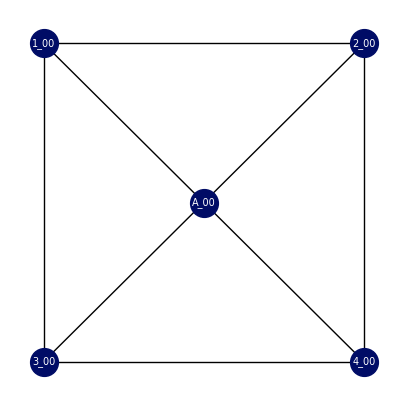

In [2]:
# Initial seed graph for this example
# The graph is the main building block that will be used to create the HSF network
# It has 5 nodes and 6 edges

A = np.array(
  [
    [0, 1, 1, 1, 1],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 0, 1, 1, 0]
  ], dtype=float
)

# Plot seed graph ----
fig, ax = plt.subplots(1, 1)
G = nx.Graph(A)

pos = {
  0 : np.array([0, 0]),
  1 : np.array([-1, 1]),
  2 : np.array([1, 1]),
  3 : np.array([-1, -1]),
  4 : np.array([1, -1])
}

nx.draw(
  G, pos=pos, ax=ax,
  node_size=400,
  node_color="#000C66",
  labels = {
    0 : "A_00",
    1 : "1_00",
    2 : "2_00",
    3 : "3_00",
    4 : "4_00"
  },
  font_size=7,
  font_color="white"
)
fig.set_figheight(5)
fig.set_figwidth(5)



## Step 2 - Grow the hierarchical scale-free network

The `HSF` class wraps the deterministic construction: every iteration replicates the motif `R` times and connects the replicas across `L` hierarchy levels. Key knobs:

- `R`: number of motif replicas per generation
- `L`: number of hierarchy levels
- `linear_separation_factor` and `exponential_separation_factor`: layout parameters that keep replicas from overlapping in the plots

Calling `fit()` creates the hierarchical edge list and node labels; `fit_matrix()` converts it into an adjacency matrix so we can hand it to NetworkX and, ultimately, to LinkNodeCommunity.


In [3]:
R = 4       # Replicas
L = 2      # Levels

pos_seed = {
  "A_0_0" : np.array([0, 0]),
  "1_0_0" : np.array([-1, 1]),
  "2_0_0" : np.array([1, 1]),
  "3_0_0" : np.array([-1, -1]),
  "4_0_0" : np.array([1, -1])
}

model = HSF(
    A, pos_seed,
    "A_0_0",
    R,
    L,
    linear_separation_factor=3,
    exponential_separation_factor=2
)

model.fit()   # Create the edgelist and positions
model.to_dense_adjacency_matrix() # Create the adjacency matrix from the edgelist

G = nx.Graph(model.A)

## Step 3 - Inspect the heuristic hierarchy

`model.get_membership_level` returns the label assignments produced by the deterministic generator. The plots below show the heuristic communities at levels 0 and 1. They serve as a baseline: the replicas of the original motif appear as level-0 groups nested inside four level-1 hubs.

These partitions arise from how the generator wires replicas; they are not yet informed by link similarities. To understand which of these blocks survives once we analyze the actual connectivity, we now switch to LinkNodeCommunity.


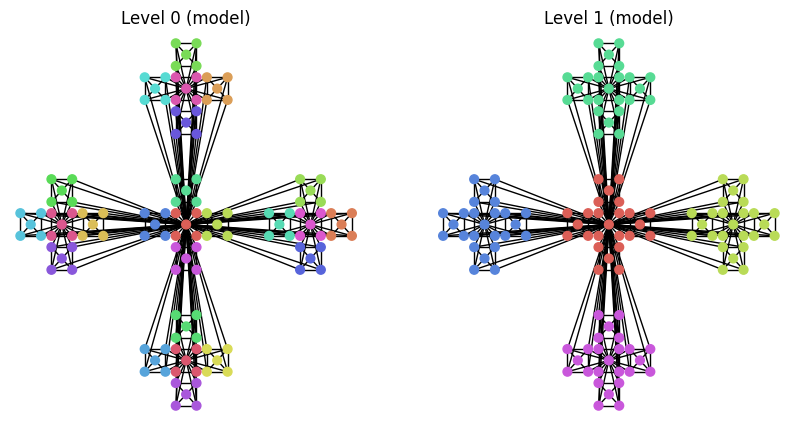

In [4]:
# We can visualize the different levels of the hierarchy
# Level 0 is the lowest level, and level L-1 is the highest level
# Each level has a different partition of the nodes

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

partition_level =  model.get_membership_level(model.labels, R, level=0)
model.graph_network(G, partition_level, linewidth=1, ax=ax[0])
_ = ax[0].set_title("Level 0 (model)")
partition_level =  model.get_membership_level(model.labels, R, level=1)
model.graph_network(G, partition_level, linewidth=1, ax=ax[1])
_ = ax[1].set_title("Level 1 (model)")

# As seen in the plots, the communities at level 0 are nested within the communities at level 1
# NOTE: This partitions are heuristics, based in levels of the hierarchy.
# However, they do not necessarily reflect the actual communities in the network encoded in
# the network structure.
# To find the actual communities, we can use a community detection algorithm
# such as LinkNodeCommunity, and then compare the results with the heuristic partitions.
# This is done below.

In [5]:
# Clustering with LinkNodeCommunity
cluster = lnc.Clustering(
    G, 
    similarity_index="tanimoto_coefficient",
    edge_complete=False,
  )
cluster.fit(use_parallel=False, method="matrix", verbose=1)

[linksim] Initialized with N=125, M=360, verbose=1
[linksim] Starting fit_linksim_condense_matrix()
[linksim] Completed fit_linksim_condense_matrix()
[linkstat] Initialized with N=125, M=360, verbose=1, force=0, edge_complete=0
[linkstat] Starting fit_matrix workflow
[linkstat] Completed fit_matrix workflow
[link2node] Initialized with N=125, M=360, verbose=1, edge_complete=0
[link2node] Starting fit_matrix workflow
[link2node] Starting fit_matrix_undirected workflow
[link2node] Some node communities remain unmerged after processing all link merges.
            This is deliberate behaviour to ensure a full dendrogram is produced.
[link2node] Completed fit_matrix_undirected workflow
[link2node] Completed fit_matrix workflow


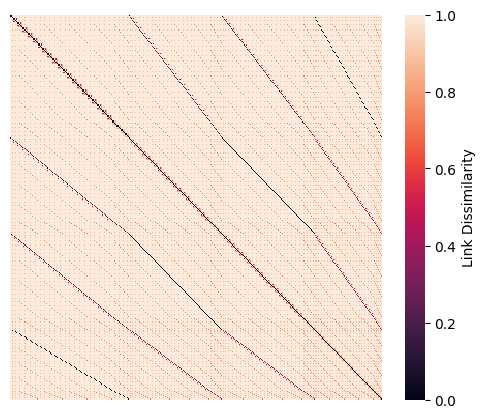

In [6]:
# Observe the patterns in the link distance matrix of an HSF network.
# Each darker diagonal block corresponds to nodes in a hub node, whose
# similarity is higher within the hub than between hubs.

from scipy.spatial.distance import squareform
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
g = sns.heatmap(
    squareform(cluster.linkdist_matrix),
    xticklabels=False, yticklabels=False,
    cbar_kws={"label": "Link Dissimilarity"},
    ax=ax
)

# NOTE: this representation is possible due to the edgelist being ordered
# according to the construction of the HSF network. In general, the edgelist
# will not be ordered, and the link distance matrix will not show any pattern.
# Still, we observed that the communities found by LinkNodeCommunity
# are robust against the relabeling of nodes in the edgelist.

In [7]:
# Compute the node-community hierarchy matrix
cluster.node_community_hierarchy_matrix(use_parallel=False)

## Step 4 - Maximize the average link density `D`

`lnc_equivalence_partition` scans the hierarchy learned by LinkNodeCommunity and returns the cut that maximizes the chosen statistic. Here we pick `D`, the average link density across communities. After retrieving the node partition we run the `NOCFinder` to obtain node-cover assignments, then plot them with `graph_network_covers`. The pie charts encode the membership of each node across link communities, while the grey markers correspond to nodes left as singletons after the refinement step.


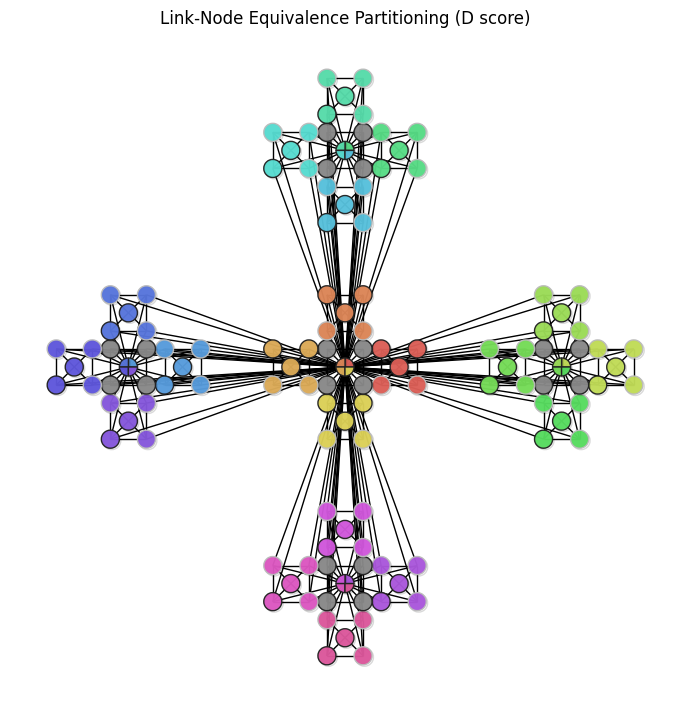

In [8]:
score = "D"

# Link-node equivalence partitioning (D score)
# Returns (link communities, node communities, merge height)
node_partition_dict  = cluster.equivalence_partition(score=score)
node_partition = np.array(list(node_partition_dict.values()))
node_partition = collapsed_partition(node_partition)  # assigns singletons membership to -1

# Compute NOCs using the node partition
nocs_model = lnc.NOCFinder(
    G, node_partition,
    undirected=True,
    similarity_index="cosine_similarity",
    tie_policy="include_equal"
)

nocs_model.fit(
    cluster.linksim.source_sim_matrix,
    cluster.linksim.target_sim_matrix
)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

graph_network_covers(
    G,
    model.pos,
    nocs_model.node_cover_partition,
    node_partition,
    nocs_model.single_node_cover_map,
    nocs_model.single_nodes_cover_scores,
    palette="hls",
    scale=0.3,
    pie_radius=0.15,
    single_node_color="#888888",
    wedgewidth=1,
    edge_color="#000000",
    alpha_line=1,
    edge_linewidth=1,
    connectionstyle="arc3",
    arrowstyle="-",
    hide_labels=True,
    ax=ax
)

_ = ax.set_title("Link-Node Equivalence Partitioning (D score)")

## Observations

- The `D`-optimal cut aligns with the intuitive hierarchy of the deterministic model: each hub keeps its four satellites because together they form dense link bundles.
- After the `NOCFinder` refinement, the pies highlight nodes with clear community affiliations, while grey singletons reveal structural connectors that bridge hubs.
- Because the input graph is undirected we read the result qualitatively, yet the overlap between the `D` optimum and the generator's level-0 blocks confirms that LinkNodeCommunity recovers the hub-and-spoke organisation characteristic of the model.
